In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import sys
import time
from multiprocessing import Process, Pool
import warnings
warnings.simplefilter('ignore')

# Add module path to system path
module_paths = ['..', 
               ]
for module_path in module_paths:
    if os.path.abspath(os.path.join(module_path)) not in sys.path:
        sys.path.insert(0, module_path)
    
    
# For convenience
import numpy as np
import pandas as pd

from epn_mining.main import load_states, save, load
from epn_mining.preparation.pulsar import Population
from epn_mining.topology import topology
from epn_mining.analysis.stats import (
    centroid as compute_centroid, 
    # evaluate_DPGMM,
    convert_x_to_phase
)
from epn_mining.analysis import stats
from epn_mining.analysis.distance import (check_bound, check_min_max, check_neg, Distance)

from epn_mining.preparation.signal import (
    shift_max_to_center, 
    shift_centroid_to_center,
    best_alignment
)

from epn_mining.analysis import plotting

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits import axes_grid1
from matplotlib import rc
from matplotlib import style, collections as mc, colors, cm
import matplotlib.patheffects as PathEffects

style.use('default')

import json
from sklearn import mixture
from scipy.stats import norm, linregress, gaussian_kde
from joblib import parallel_backend
from tqdm import tqdm

# from dtaidistance import dtw

from dtw import dtw

import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import histogram, knuth_bin_width

import lmfit

import copy

# Set session variables
verbose = True
state_store=True

pink = (230/255, 29/255, 95/255, 1)
pink_translucid = (230/255, 29/255, 95/255, .2)
blue = (47/255, 161/255, 214/255, 0.2)
blue_full = (47/255, 161/255, 214/255, 1)

cmap = cm.get_cmap('cubehelix').reversed()
# cmap = cm.get_cmap('tab20')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
state_prefix = 'frb_one_offs'

# epn_metadata = load('epn_metadata', state_prefix=state_prefix)
population = load('population', state_prefix=state_prefix)

In [6]:
# population.pulsars


In [7]:
metric = 'DTW'
stokes_to_include = [ 'model',]
freq_ids_to_include = [2]
_4freqs_ = True if len(freq_ids_to_include) > 1 else False
print (_4freqs_)

min_snr = 20

from dtw import rabinerJuangStepPattern

penalty = None
step_pattern = 'asymmetric' # rabinerJuangStepPattern(6, "d") # 'symmetric2'#'symmetricP05' #['', 'symmetric2']
window_type  = 'sakoechiba' #['sakoechiba', None]
window_args  = {'window_size': 256} #{'window_size': 512} #[{'window_size':204}, {}]
open_begin   = False #[False, True, True]
open_end     = False #[False, True, True]

# state_name = None
state_name = '%sbin%s_graph_%s%s_%s' % (len(freq_ids_to_include) if _4freqs_ else '',
                                             '' if _4freqs_ else 's' + str(freq_ids_to_include[0]),
                                             step_pattern, 
                                             '_%s' % window_type if window_type is not None else '',                 
                                             stokes_to_include[0]
                                            )

cropped = False
verbose = True

print ('state_name', state_name)

False
state_name bins2_graph_asymmetric_sakoechiba_model


In [10]:
# distances, population_graph_indices, graph_population_indices = load(state_name, state_prefix=state_prefix + '_L_V')
# distances = load('distances', state_prefix=state_prefix)
# population_graph_indices = load('population_graph_indices', state_prefix=state_prefix)
# graph_population_indices = load('graph_population_indices', state_prefix=state_prefix)


distances, population_graph_indices, state_prefix, \
graph_population_indices, sequence_population, sequence_indices, mst = load('graph', state_prefix ='FRB_one_offs')

In [11]:
mst = topology.spanning_tree(distances, type='minimum', verbose=verbose)
sequence_population, sequence_indices, mst = topology.longest_path(mst,
                                                                   population.as_array(),
                                                                   graph_population_indices,
                                                                   verbose=verbose)
elongation, normalized_elongation  =  mst.elongation()

elongation_dict = {}
elongation_dict[state_prefix] = {'elongation' : elongation,
                                 'normalized_elongation' : normalized_elongation,
                                 'length': mst.length(),
                                 'half_width': mst.half_width(),
                                 'longest_path' : len(sequence_population),
                                 'N' : mst.V}

# Plotting variables
contracted = False
plot_polarization = False
plot_pa = False
plot_stokes_I = True
# colour_by = 'branch'
colour_by = 'rankin_class'
print_bname = True
annotate = True

Compute minimum spanning tree
Compute longest path in minimum spanning tree


In [14]:
from epn_mining.plotting.mst import plot
plot?

Signature:
plot(
    population,
    mst,
    freq_ids_to_include=[2, 3, 4, 5],
    colour_by='branch',
    contracted=False,
    contracted_mst_indices=None,
    phase_thres=0.5,
    plot_stokes_I=True,
    plot_pa=False,
    plot_polarization=False,
    annotate=False,
    print_bname=False,
    verbose=False,
    file_location='images/',
    filename='mst',
    file_extension='pdf',
    return_population=False,
)
Docstring: <no docstring>
File:      ~/Documents/code/graph_profiles/epn_mining/plotting/mst.py
Type:      function

Saved to images/mst.pdf


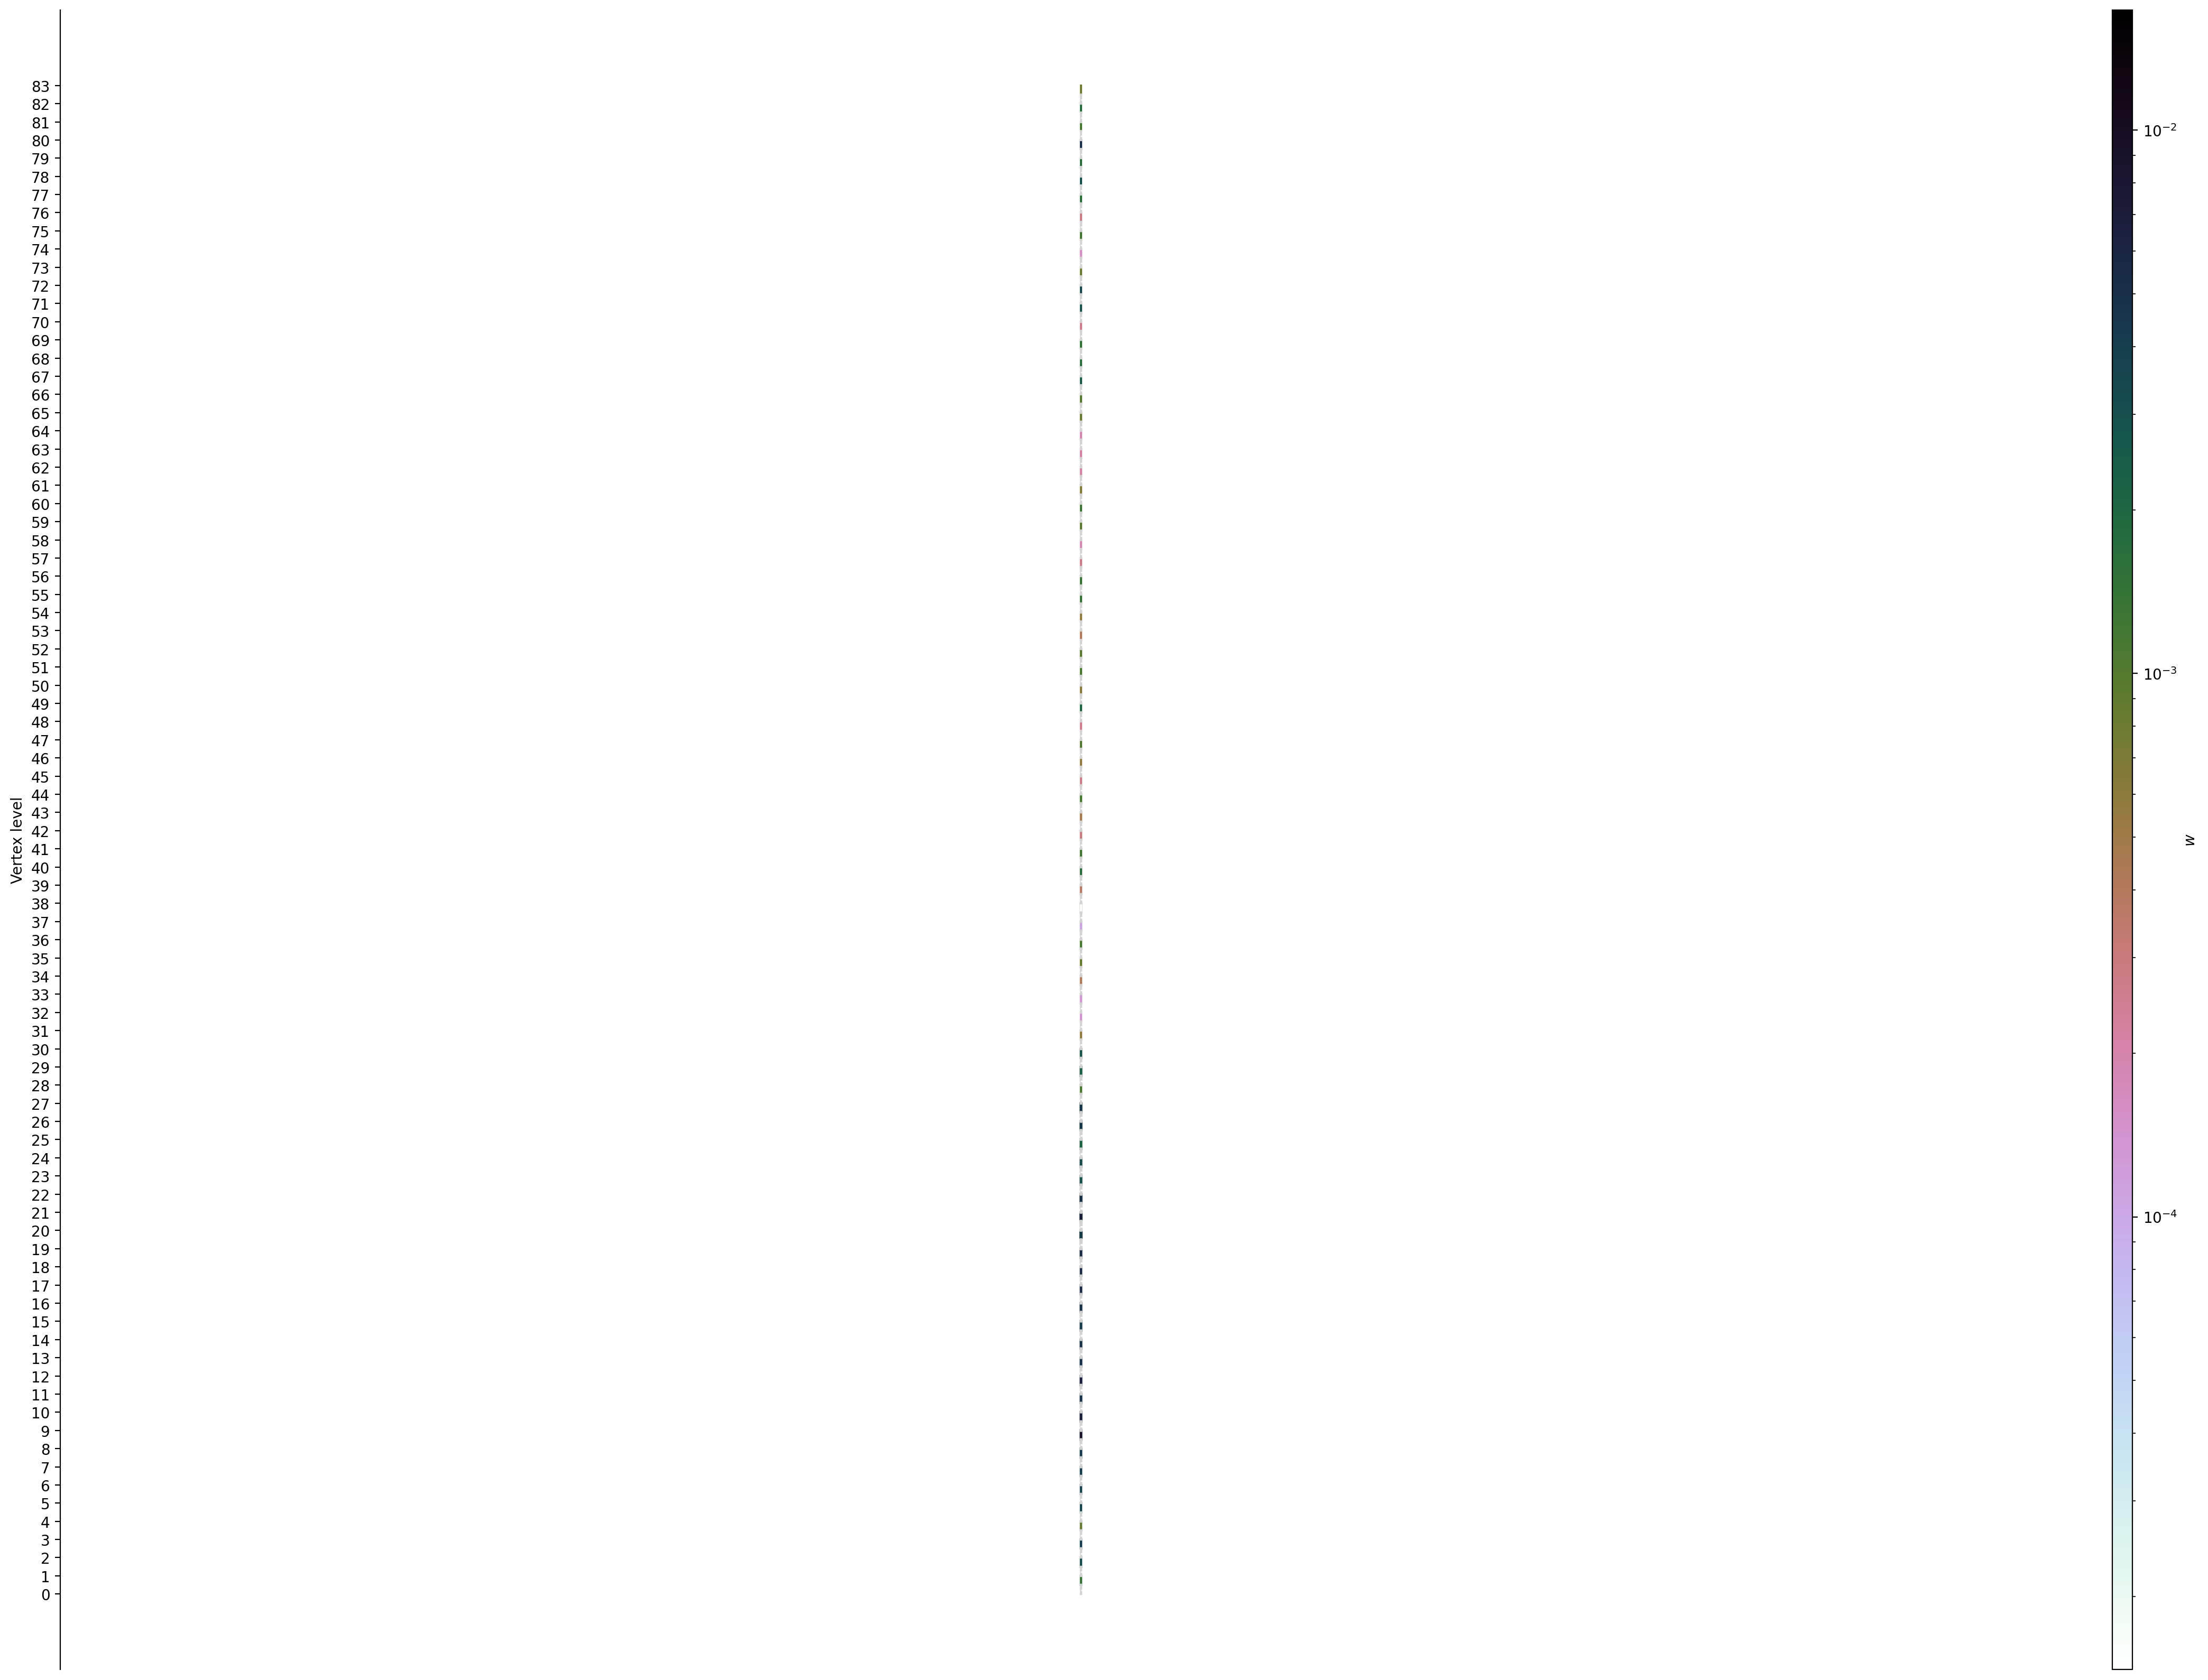

In [16]:
population = plot(population, 
                  mst, 
                  freq_ids_to_include,
                  colour_by='branch',
                  contracted=False,
                  plot_stokes_I=False, 
                  contracted_mst_indices=None,
                  phase_thres=0,
                  return_population=True)

In [ ]:
kk = 10
kk = 20
kk = 0
print (kk, population.as_array()[kk].predicted_class)